Setup and import modules

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from tensorflow.keras import datasets, layers, models, utils
import numpy as np
import matplotlib.pyplot as plt

Import data sets

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Train.csv to Train.csv


KeyboardInterrupt: ignored

In [ ]:
df = pd.read_csv("Train.csv")
df

,ID,location,temp,precip,rel_humidity,wind_dir,wind_spd,atmos_press,target
0,ID_train_0,C,"nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...",45.126304
1,ID_train_1,D,"22.53333333,21.71666667,20.83333333,20.9833333...","0.102,0.0,0.0,0.0,0.0,0.0,0.0,0.034,0.017,0.01...","0.744583333,0.808083333,0.911166667,0.91633333...","281.6643101,89.15629262,81.96853891,291.018632...","2.3775,1.126666667,0.700833333,0.3416666670000...","90.32,90.3775,90.44083333,90.4725,90.45416667,...",79.131702
2,ID_train_10,A,"28.975,27.95,29.6,26.425,22.09166667,21.775,22...","0.0,0.0,0.0,0.102,0.136,0.0,0.0,2.16,1.276,0.0...","0.573333333,0.597166667,0.5668333329999999,0.6...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","88.55166667,88.46416667,88.31916667,88.24,88.2...",32.661304
3,ID_train_100,A,"22.96666667,24.26666667,25.275,25.625,25.86666...","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.77,3.012,1.0...","0.8430833329999999,0.79025,0.7375,0.728,0.7049...","300.0850574,293.6769595,294.5174647,301.921416...","1.446666667,1.1925,1.324166667,1.5441666669999...","88.615,88.53083333,88.4,88.27166667,88.2075,88...",53.850238
4,ID_train_1000,A,"21.875,21.575,21.525,21.43333333,20.50833333,1...","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.8564166670000001,0.874916667,0.879833333,0.8...","21.83997432,17.05405341,89.26406044,123.585424...","0.1975,0.244166667,0.411666667,0.56,0.5775,0.4...","88.55666667,88.64083333,88.65833333,88.6475,88...",177.418750
...,...,...,...,...,...,...,...,...,...
15534,ID_train_9995,A,"22.71666667,16.93333333,18.03333333,18.975,19....","31.467,31.842,0.34,0.0,0.0,0.119,0.0,0.017,0.0...","0.794090909,0.97425,0.997583333,0.9985,0.999,0...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","88.27666667,88.24333333,88.18166667,88.1758333...",44.850286
15535,ID_train_9996,E,"25.375,26.025,26.4,26.23333333,25.7,24.9,23.20...","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.685333333,0.6549166670000001,0.6435833329999...","176.5438256,196.5264893,177.1717795,151.268141...","1.328333333,1.278333333,1.535833333,2.315,1.92...","88.43666667,88.34583333,88.26083333,88.1741666...",24.330455
15536,ID_train_9997,D,"26.09166667,28.975,30.31666667,30.96666667,30....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.78175,0.5780833329999999,0.513333333,0.50233...","121.7060158,147.2472237,87.95942197,121.598728...","0.936666667,1.044166667,1.239166667,1.51083333...","90.61583333,90.44916667,90.32916667,90.27,90.2...",38.972128
15537,ID_train_9998,D,"29.225,30.0,29.55,29.66666667,27.725,24.466666...","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.6283333329999999,0.605833333,0.594166667,0.5...","156.4757306,168.1802199,33.83625816,352.712136...","1.330833333,1.466666667,0.9075,1.060833333,0.8...","90.31416667,90.23916667,90.20166667,90.2225,90...",41.720952


In [ ]:
df_locs = {}
df_locs['A'] = df[df["location"] == 'A']
df_locs['B'] = df[df["location"] == 'B']
df_locs['C'] = df[df["location"] == 'C']
df_locs['D'] = df[df["location"] == 'D']
df_locs['E'] = df[df["location"] == 'E']
df_locs

{'A':                    ID  ...      target
 2         ID_train_10  ...   32.661304
 3        ID_train_100  ...   53.850238
 4       ID_train_1000  ...  177.418750
 7      ID_train_10002  ...   55.051143
 8      ID_train_10003  ...  205.215333
 ...               ...  ...         ...
 15518   ID_train_9980  ...   44.962558
 15519   ID_train_9981  ...  129.433636
 15528    ID_train_999  ...   38.138182
 15531   ID_train_9992  ...   24.302955
 15534   ID_train_9995  ...   44.850286
 
 [5122 rows x 9 columns], 'B':                    ID  ...      target
 9      ID_train_10004  ...   25.580541
 53     ID_train_10044  ...   63.030385
 88     ID_train_10076  ...   27.240250
 92      ID_train_1008  ...   39.807949
 128    ID_train_10111  ...    8.681000
 ...               ...  ...         ...
 15349   ID_train_9828  ...   45.900732
 15361   ID_train_9839  ...   42.629762
 15364   ID_train_9841  ...  108.219024
 15381   ID_train_9857  ...   50.928837
 15494   ID_train_9959  ...   33.557619
 
 

Clean up dataframes.

In [ ]:
col = ["temp","precip","rel_humidity","wind_dir","wind_spd","atmos_press"]
munged_data = {}
targets = {}
for key in df_locs:
  df_locs[key].drop("location",axis=1, inplace=True)
  df_locs[key].drop("ID",axis=1,  inplace=True) 
  new_dfs= []
  df2=df_locs[key]
  for header in col:
    temp_df = pd.DataFrame(df2[header].str.split(',').tolist())
    for i, column in enumerate(list(temp_df.columns)):
      temp_df[column] = pd.to_numeric(temp_df[column],errors='coerce')
      temp_df.rename(columns={ temp_df.columns[i]: header+'_'+str(column) }, inplace = True)

    new_dfs.append(temp_df)
    df2.drop(header, axis=1, inplace=True)

  tt = np.stack(new_dfs)
  t_array = tt
  t_array = t_array.transpose([1,2,0])
  samples = []
  tgts = []
  for s in t_array:
    working_df = pd.DataFrame(s)
    working_df.dropna(inplace=True)
    if len(working_df > 20):
      for i in range(0,len(working_df)-21):
        samples.append(working_df.iloc[i:i+20])
        tgts.append(working_df.iloc[i+21]) 
  munged_data[key] = np.stack(samples)
  targets[key] = np.stack(tgts)

targets['A'].shape

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(361359, 6)

In [ ]:
models = {}

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.BatchNormalization(input_shape=(20,6)))
model.add(tf.keras.layers.LSTM(32))
model.add(tf.keras.layers.Dense(6))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 20, 6)             24        
_________________________________________________________________
lstm (LSTM)                  (None, 32)                4992      
_________________________________________________________________
dense (Dense)                (None, 6)                 198       
Total params: 5,214
Trainable params: 5,202
Non-trainable params: 12
_________________________________________________________________


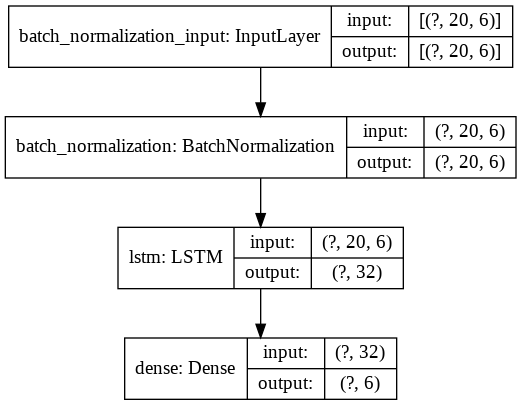

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=True, dpi=96
)


In [ ]:
histories = {}

In [ ]:
to_train = 'E'

models[to_train] = model
data_train = munged_data[to_train][:(len(munged_data[to_train]) // 10) * 8]
data_val = munged_data[to_train][(len(munged_data[to_train]) // 10) * 8:]

target_train = targets[to_train][:(len(targets[to_train]) // 10) * 8]
target_val = targets[to_train][(len(targets[to_train]) // 10) * 8:]
((data_train.shape, target_train.shape),(data_val.shape, target_val.shape))

(((215872, 20, 6), (215872, 6)), ((53973, 20, 6), (53973, 6)))

In [ ]:
checkpoint_path = "training_E.ckpt"

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
models[to_train].compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mse')
histories[to_train] = models[to_train].fit(data_train, target_train, epochs=1000, callbacks=[early_stop, cp_callback], validation_data=(data_val, target_val))

Epoch 1/1000
6740/6746 [============================>.] - ETA: 0s - loss: 4040.8604
Epoch 00001: saving model to training_E.ckpt
6746/6746 [==============================] - 51s 8ms/step - loss: 4039.1282 - val_loss: 2165.4612
Epoch 2/1000
6746/6746 [==============================] - ETA: 0s - loss: 1976.1528
Epoch 00002: saving model to training_E.ckpt
6746/6746 [==============================] - 47s 7ms/step - loss: 1976.1528 - val_loss: 1759.3439
Epoch 3/1000
6740/6746 [============================>.] - ETA: 0s - loss: 1640.3080
Epoch 00003: saving model to training_E.ckpt
6746/6746 [==============================] - 47s 7ms/step - loss: 1640.2250 - val_loss: 1458.8143
Epoch 4/1000
6742/6746 [============================>.] - ETA: 0s - loss: 1420.4478
Epoch 00004: saving model to training_E.ckpt
6746/6746 [==============================] - 46s 7ms/step - loss: 1420.4276 - val_loss: 1238.7788
Epoch 5/1000
6742/6746 [============================>.] - ETA: 0s - loss: 1268.4965
Epoch 00

# New Section

In [ ]:
(models['E'].predict(data_val)[0], target_val[0])

(array([21.451345  ,  0.20424089,  0.8056728 , 79.364586  ,  1.4305003 ,
        88.77622   ], dtype=float32),
 array([2.22583333e+01, 1.70000000e-02, 8.29000000e-01, 3.89159780e+01,
        1.16916667e+00, 8.83883333e+01]))

In [ ]:
new_model = tf.keras.models.Sequential()
new_model.add(tf.keras.layers.BatchNormalization(input_shape=(20,6)))
new_model.add(tf.keras.layers.LSTM(32))
new_model.add(tf.keras.layers.Dense(6))
new_model.load_weights("training_E.ckpt")
(new_model.predict(data_val)[0], target_val[0])

(array([21.451345  ,  0.20424089,  0.8056728 , 79.364586  ,  1.4305003 ,
        88.77622   ], dtype=float32),
 array([2.22583333e+01, 1.70000000e-02, 8.29000000e-01, 3.89159780e+01,
        1.16916667e+00, 8.83883333e+01]))

In [ ]:
models['A'] = model
histories = {}
histories['A'] = history

In [ ]:
munged_data['E'].shape

(269845, 20, 6)

In [ ]:
for key in ['B','C','D','E']:
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.BatchNormalization(input_shape=(20,6)))
  model.add(tf.keras.layers.LSTM(32))
  model.add(tf.keras.layers.Dense(6))

  data_train = munged_data[key][:(len(munged_data[key]) // 10) * 8]
  data_val = munged_data[key][(len(munged_data[key]) // 10) * 8:]
  target_train = targets[key][:(len(targets[key]) // 10) * 8]
  target_val = targets[key][(len(targets[key]) // 10) * 8:]
  early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
  model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mse')
  history = model.fit(data_train, target_train, epochs=1000, callbacks=[early_stop], validation_data=(data_val, target_val))
  models[key] = model
  histories[key] = history

Epoch 1/1000
1661/1661 [==============================] - 12s 7ms/step - loss: 8478.6631 - val_loss: 6648.1421
Epoch 2/1000
1661/1661 [==============================] - 12s 7ms/step - loss: 4892.6309 - val_loss: 3927.4429
Epoch 3/1000
1661/1661 [==============================] - 12s 7ms/step - loss: 2893.1135 - val_loss: 2375.5352
Epoch 4/1000
1661/1661 [==============================] - 13s 8ms/step - loss: 1908.0098 - val_loss: 1796.9633
Epoch 5/1000
1661/1661 [==============================] - 12s 7ms/step - loss: 1708.7113 - val_loss: 1759.3126
Epoch 6/1000
1661/1661 [==============================] - 12s 7ms/step - loss: 1704.8676 - val_loss: 1757.4417
Epoch 7/1000
1661/1661 [==============================] - 12s 7ms/step - loss: 1705.0071 - val_loss: 1758.5652
Epoch 8/1000
1661/1661 [==============================] - 12s 7ms/step - loss: 1705.0105 - val_loss: 1758.2451
Epoch 9/1000
1661/1661 [==============================] - 12s 7ms/step - loss: 1704.9858 - val_loss: 1759.0718
E